In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
import pickle
import joblib
from sklearn.preprocessing import normalize
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier 
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds
from tensorflow.keras.layers import Dropout, Flatten, Dense, Input, LSTM
from tensorflow.keras import models, layers, Model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

/kaggle/input/birdfrog-eda/test_labels.pkl
/kaggle/input/birdfrog-eda/train_features.pkl
/kaggle/input/birdfrog-eda/filename-noise.wav
/kaggle/input/birdfrog-eda/filename.wav
/kaggle/input/birdfrog-eda/__results__.html
/kaggle/input/birdfrog-eda/train_labels.pkl
/kaggle/input/birdfrog-eda/test_features.pkl
/kaggle/input/birdfrog-eda/train_noOS_labels.pkl
/kaggle/input/birdfrog-eda/train_noOS_features.pkl
/kaggle/input/birdfrog-eda/__notebook__.ipynb
/kaggle/input/birdfrog-eda/__output__.json
/kaggle/input/birdfrog-eda/custom.css
/kaggle/input/birdfrog-eda/__results___files/__results___15_0.png
/kaggle/input/birdfrog-eda/__results___files/__results___25_0.png
/kaggle/input/birdfrog-eda/__results___files/__results___10_0.png
/kaggle/input/birdfrog-eda/__results___files/__results___19_0.png
/kaggle/input/birdfrog-eda/__results___files/__results___31_0.png
/kaggle/input/birdfrog-eda/__results___files/__results___27_0.png
/kaggle/input/birdfrog-eda/__results___files/__results___21_0.png
/ka

In [2]:
X_train = joblib.load('/kaggle/input/birdfrog-eda/train_features.pkl')
X_test = joblib.load('/kaggle/input/birdfrog-eda/test_features.pkl')
print(X_train.shape,X_test.shape)

(1226, 128, 1000, 3) (304, 128, 1000, 3)


In [3]:
y_train = np.array(joblib.load('/kaggle/input/birdfrog-eda/train_labels.pkl'))
y_test = np.array(joblib.load('/kaggle/input/birdfrog-eda/test_labels.pkl'))
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=123)
print(X_train.shape, y_train.shape,X_test.shape, y_test.shape,X_val.shape, y_val.shape)

(919, 128, 1000, 3) (919,) (304, 128, 1000, 3) (304,) (307, 128, 1000, 3) (307,)


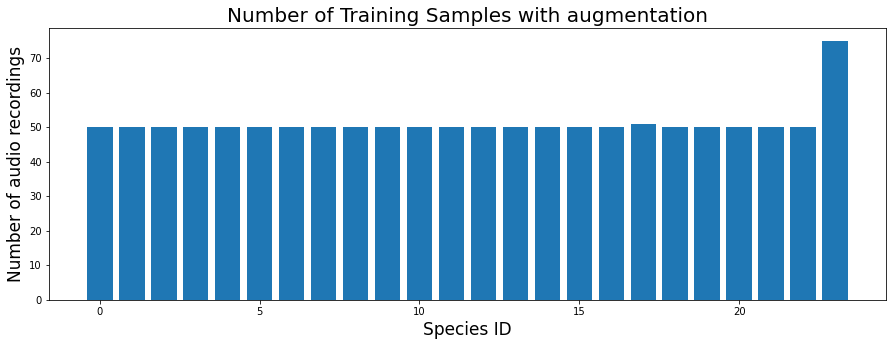

In [4]:
unique, counts = np.unique(np.concatenate((y_train,y_val)),return_counts=True)
values=dict(zip(unique,counts))
fig, ax = plt.subplots(figsize=(15,5))
barlist=plt.bar(values.keys(),values.values(), label='Minority samples')
plt.xlabel('Species ID', fontsize=17)
plt.ylabel('Number of audio recordings', fontsize=17)
plt.title('Number of Training Samples with augmentation', fontsize=20)
plt.show()

# RNN Modeling

## RNN does not seem to be able to mix types of data (1D spectral bandwidth with 2D spectrogram or 2D MFCC's for example). The best results are obtained from using only one type of data, the MFCC's.

In [5]:
input_shape=(128,1000)
model = keras.Sequential()
model.add(LSTM(250,input_shape=input_shape))
model.add(Dropout(0.2))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(48, activation='relu'))
model.add(Dense(24, activation='softmax'))
model.compile(optimizer='rmsprop',loss='SparseCategoricalCrossentropy',metrics=['acc'])
history = model.fit(X_train[:,:,:,2], y_train, epochs=50, batch_size=72, 
                    validation_data=(X_test[:,:,:,2], y_test), verbose=2,shuffle=False)

Epoch 1/50
13/13 - 7s - loss: 2.8612 - acc: 0.1502 - val_loss: 2.1377 - val_acc: 0.3289
Epoch 2/50
13/13 - 1s - loss: 2.2639 - acc: 0.3025 - val_loss: 1.4611 - val_acc: 0.5033
Epoch 3/50
13/13 - 1s - loss: 1.8627 - acc: 0.4146 - val_loss: 1.0901 - val_acc: 0.6447
Epoch 4/50
13/13 - 1s - loss: 1.5907 - acc: 0.4940 - val_loss: 0.9030 - val_acc: 0.7204
Epoch 5/50
13/13 - 1s - loss: 1.4142 - acc: 0.5550 - val_loss: 0.7235 - val_acc: 0.7566
Epoch 6/50
13/13 - 1s - loss: 1.2712 - acc: 0.6268 - val_loss: 0.6019 - val_acc: 0.7697
Epoch 7/50
13/13 - 1s - loss: 1.1192 - acc: 0.6714 - val_loss: 0.4860 - val_acc: 0.8816
Epoch 8/50
13/13 - 1s - loss: 1.1180 - acc: 0.6670 - val_loss: 0.4008 - val_acc: 0.8947
Epoch 9/50
13/13 - 1s - loss: 0.9009 - acc: 0.7476 - val_loss: 0.4283 - val_acc: 0.8618
Epoch 10/50
13/13 - 1s - loss: 0.7981 - acc: 0.7704 - val_loss: 0.5593 - val_acc: 0.8322
Epoch 11/50
13/13 - 1s - loss: 0.8390 - acc: 0.7573 - val_loss: 0.3846 - val_acc: 0.8618
Epoch 12/50
13/13 - 1s - loss:

In [6]:
TrainLoss, Trainacc = model.evaluate(X_train[:,:,:,2],y_train)
TestLoss, Testacc = model.evaluate(X_test[:,:,:,2], y_test)
y_pred=model.predict(X_test[:,:,:,2])
print('TrainLoss: %f, Train accuracy %f, TestLoss: %f, Test Accuracy: %f ' %(TrainLoss,Trainacc,TestLoss,Testacc))
print('Confusion_matrix: ',tf.math.confusion_matrix(y_test, np.argmax(y_pred,axis=1)))

10/10 [==============================] - 0s 14ms/step - loss: 0.6864 - acc: 0.8717
TrainLoss: 0.388913, Train accuracy 0.920566, TestLoss: 0.686426, Test Accuracy: 0.871711 
Confusion_matrix:  tf.Tensor(
[[10  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  2  0]
 [13  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  8  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0]
 [ 0  0  0  4  0  0  0  0  0  0  0  0  0  0  0  0  0  0  9  0  0  0  0  0]
 [ 0  0  0  0 10  0  0  0  0  0  0  0  0  0  0  0  3  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  9  0  1  0  0  2  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0 12  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0 12  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0 12  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  8  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0 13  0  0  0  0

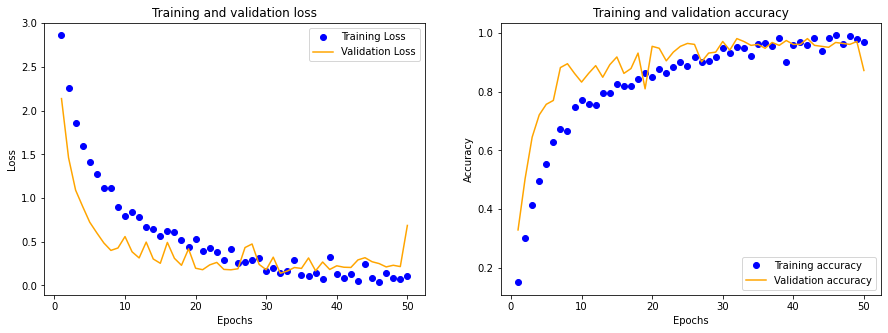

In [7]:
history_dict=history.history
loss_values=history_dict['loss']
acc_values=history_dict['acc']
val_loss_values = history_dict['val_loss']
val_acc_values=history_dict['val_acc']
epochs=range(1,51)
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(15,5))
ax1.plot(epochs,loss_values,'bo',label='Training Loss')
ax1.plot(epochs,val_loss_values,'orange', label='Validation Loss')
ax1.set_title('Training and validation loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()
ax2.plot(epochs,acc_values,'bo', label='Training accuracy')
ax2.plot(epochs,val_acc_values,'orange',label='Validation accuracy')
ax2.set_title('Training and validation accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()
plt.show()

In [8]:
#Save model as a json file
model_json=model.to_json()
with open('/kaggle/working/RNNmodel.json','w') as file:
    file.write(model_json)

#save weights as an HDF5 file
model.save_weights('/kaggle/working/RNNmodel.h5')